# Assignment 5 – Machine Learning in R

**Author**: Chong Lu    
**Date**: 07.24.2025    
**Environment**: See `environment.yml`    
**Description**:    
This notebook explores basic machine learning using [caret/MASS/rpart/class/randomForest], including data preparation, model training, and evaluation.


## 1. Start Python, Load Libraries and Check Versions

In [45]:
# Check the versions of libraries
library(caret)
library(MASS)/
library(rpart)
library(class)
library(randomForest)
library(kernlab)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin




## 2. Load Dataset
We are going to use the iris flowers dataset. This dataset is famous because it is used as the “hello world” dataset in machine learning and statistics by pretty much everyone.

The dataset contains 150 observations of iris flowers. There are four columns of measurements of the flowers in centimeters. The fifth column is the species of the flower observed. All observed flowers belong to one of three species.

In this step we are going to load the iris data from CSV file URL.

In [11]:
# Load dataset
# define the filename
filename <- "iris.csv"
# load the CSV file from the local directory
dataset <- read.csv(filename, header=FALSE)
# set the column names in the dataset
colnames(dataset) <- c("Sepal.Length","Sepal.Width","Petal.Length","Petal.Width","Species")
dataset$Species <- as.factor(dataset$Species)

## 3. Summarize the Dataset
Now it is time to take a look at the data.

In this step we are going to take a look at the data a few different ways:

- Dimensions of the dataset.
- Peek at the data itself.
- Statistical summary of all attributes.
- Breakdown of the data by the class variable.

### 3.1 Dimensions of Dataset
We can get a quick idea of how many instances (rows) and how many attributes (columns) the data contains with the shape property.

In [12]:
# dimensions of dataset
dim(dataset)

[1] 150   5

### 3.2 Types of Attributes
We can get a quick idea of the types of the attributes. They could be doubles, integers, strings, factors and other types.

Knowing the types is important as it will give you an idea of how to better summarize the data you have and the types of transforms you might need to use to prepare the data before you model it.

In [13]:
# list types for each attribute
sapply(dataset, class)

Sepal.Length  Sepal.Width Petal.Length  Petal.Width      Species 
   "numeric"    "numeric"    "numeric"    "numeric"     "factor"

### 3.3 Peek at the Data
It is also always a good idea to actually eyeball your data.

In [15]:
# take a peek at the first 5 rows of the data
head(dataset)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
6,5.4,3.9,1.7,0.4,Iris-setosa


### 3.4 Levels of the Class
The class variable is a factor. A factor is a class that has multiple class labels or levels. Let’s look at the levels:

In [19]:
# list the levels for the class
levels(dataset$Species)

[1] "Iris-setosa"     "Iris-versicolor" "Iris-virginica"

### 3.5 Class Distribution
Let’s now take a look at the number of instances (rows) that belong to each class. We can view this as an absolute count.

In [20]:
# summarize the class distribution
percentage <- prop.table(table(dataset$Species)) * 100
cbind(freq=table(dataset$Species), percentage=percentage)

,freq,percentage
Iris-setosa,50,33.33333
Iris-versicolor,50,33.33333
Iris-virginica,50,33.33333


### 3.6 Statistical Summary
Now we can take a look at a summary of each attribute.

This includes the count, mean, the min and max values as well as some percentiles.

In [21]:
# summarize attribute distributions
summary(dataset)

  Sepal.Length    Sepal.Width     Petal.Length    Petal.Width   
 Min.   :4.300   Min.   :2.000   Min.   :1.000   Min.   :0.100  
 1st Qu.:5.100   1st Qu.:2.800   1st Qu.:1.600   1st Qu.:0.300  
 Median :5.800   Median :3.000   Median :4.350   Median :1.300  
 Mean   :5.843   Mean   :3.054   Mean   :3.759   Mean   :1.199  
 3rd Qu.:6.400   3rd Qu.:3.300   3rd Qu.:5.100   3rd Qu.:1.800  
 Max.   :7.900   Max.   :4.400   Max.   :6.900   Max.   :2.500  
            Species  
 Iris-setosa    :50  
 Iris-versicolor:50  
 Iris-virginica :50  
                     
                     
                     

## 4. Data Visualization
We now have a basic idea about the data. We need to extend that with some visualizations.

We are going to look at two types of plots:

Univariate plots to better understand each attribute.
Multivariate plots to better understand the relationships between attributes.

### 4.1 Univariate Plots
We start with some univariate plots, that is, plots of each individual variable.

Given that the input variables are numeric, we can create box and whisker plots of each.

In [22]:
# split input and output
x <- dataset[,1:4]
y <- dataset[,5]

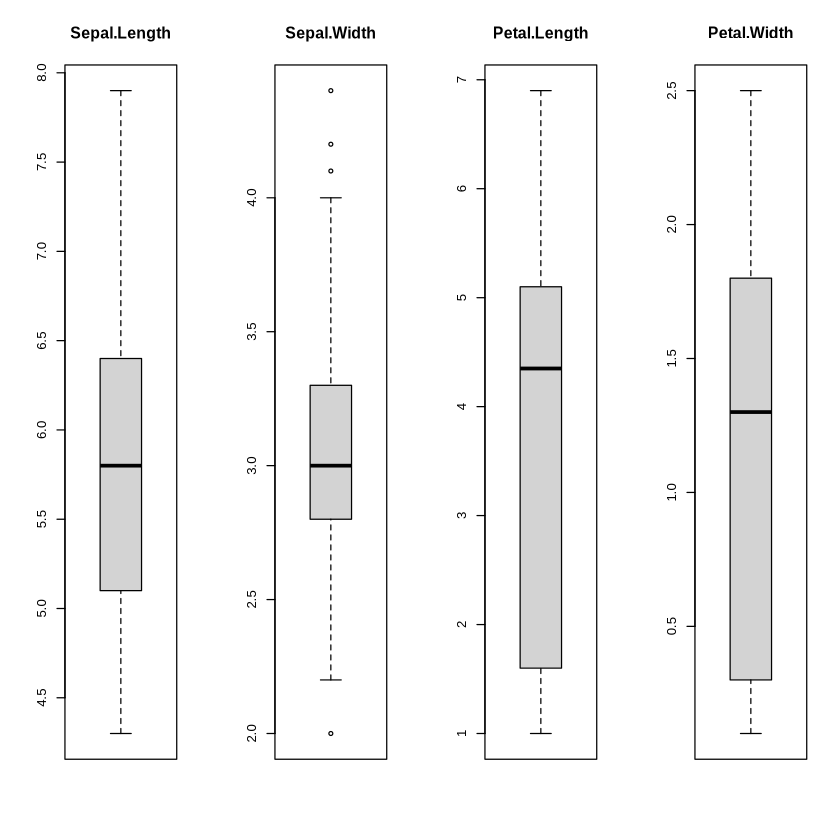

In [23]:
# boxplot for each attribute on one image
par(mfrow=c(1,4))
  for(i in 1:4) {
  boxplot(x[,i], main=names(iris)[i])
}

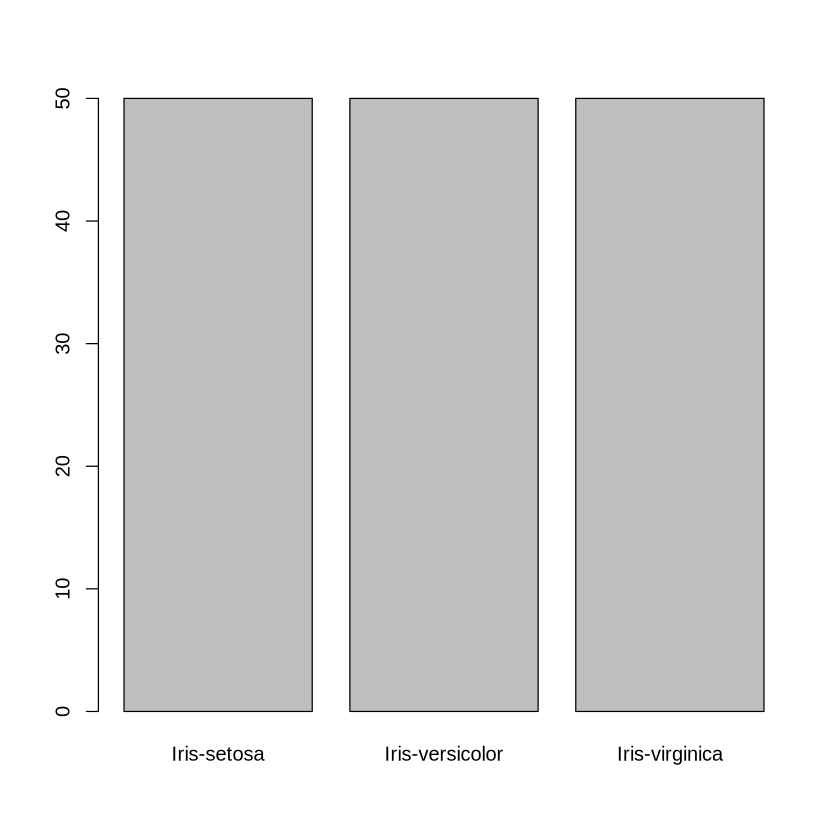

In [24]:
# barplot for class breakdown
plot(y)

### 4.2 Multivariate Plots
Now we can look at the interactions between the variables.

First, let’s look at scatterplots of all pairs of attributes. This can be helpful to spot structured relationships between input variables.

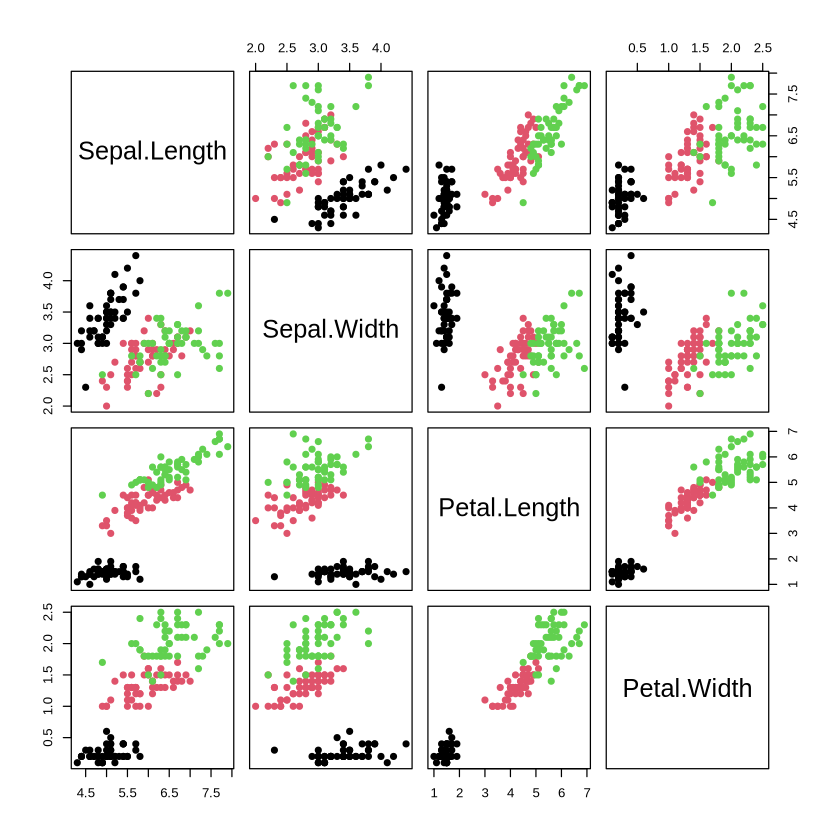

In [33]:
# scatterplot matrix
pairs(x, col = as.integer(y), pch = 19)
legend("topright", legend = levels(y), col = 1:3, pch = 19)

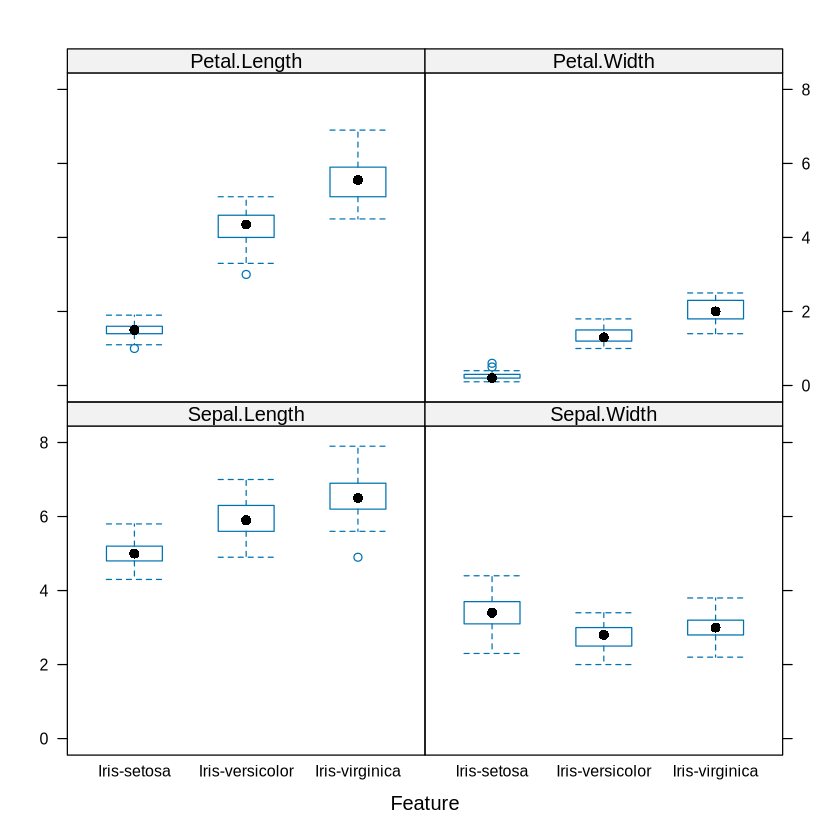

In [34]:
# box and whisker plots for each attribute
featurePlot(x=x, y=y, plot="box")

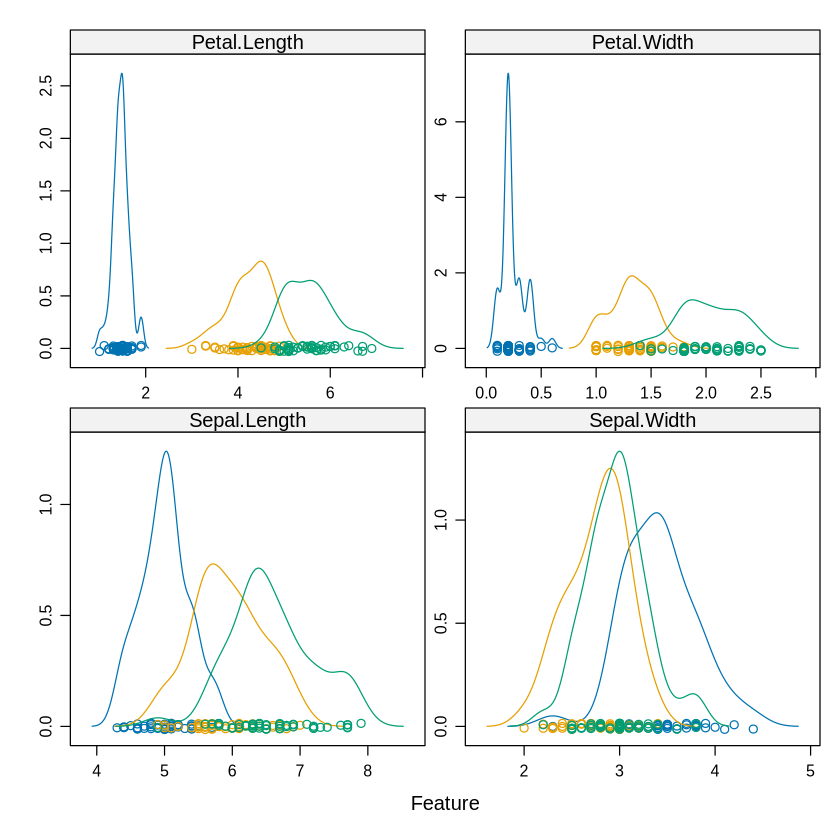

In [35]:
# density plots for each attribute by class value
scales <- list(x=list(relation="free"), y=list(relation="free"))
featurePlot(x=x, y=y, plot="density", scales=scales)

## 5. Evaluate Some Algorithms
Now it is time to create some models of the data and estimate their accuracy on unseen data.

Here is what we are going to cover in this step:

- Separate out a validation dataset.
- Set-up the test harness to use 10-fold cross validation.
- Build multiple different models to predict species from flower measurements
- Select the best model.

### 5.1 Create a Validation Dataset
We need to know that the model we created is good.

Later, we will use statistical methods to estimate the accuracy of the models that we create on unseen data. We also want a more concrete estimate of the accuracy of the best model on unseen data by evaluating it on actual unseen data.

That is, we are going to hold back some data that the algorithms will not get to see and we will use this data to get a second and independent idea of how accurate the best model might actually be.

We will split the loaded dataset into two, 80% of which we will use to train, evaluate and select among our models, and 20% that we will hold back as a validation dataset.

In [51]:
# create a list of 80% of the rows in the original dataset we can use for training
validation_index <- createDataPartition(dataset$Species, p=0.80, list=FALSE)
# select 20% of the data for validation
validation <- dataset[-validation_index,]
# use the remaining 80% of data to training and testing the models
dataset <- dataset[validation_index,]

### 5.2 Test Harness
We will use stratified 10-fold cross validation to estimate model accuracy.

This will split our dataset into 10 parts, train on 9 and test on 1 and repeat for all combinations of train-test splits.

Stratified means that each fold or split of the dataset will aim to have the same distribution of example by class as exist in the whole training dataset.

* K-fold Cross-Validation
  
  We set the random seed via the random_state argument to a fixed number to ensure that each algorithm is evaluated on the same splits of the training dataset.

  The specific random seed does not matter, learn more about pseudorandom number generators here:

* Random Number Generators for Machine Learning in Python

  We are using the metric of ‘accuracy‘ to evaluate models.
  This is a ratio of the number of correctly predicted instances divided by the total number of instances in the dataset multiplied by 100 to give a percentage (e.g. 95% accurate). We will be using the scoring variable when we run build and evaluate each model next.

In [36]:
# Run algorithms using 10-fold cross validation
control <- trainControl(method="cv", number=10)
metric <- "Accuracy"

## 5.3 Build Models
We don’t know which algorithms would be good on this problem or what configurations to use.

We get an idea from the plots that some of the classes are partially linearly separable in some dimensions, so we are expecting generally good results.

Let’s test 6 different algorithms:

- Logistic Regression (LR)
- Linear Discriminant Analysis (LDA)
- K-Nearest Neighbors (KNN).
- Classification and Regression Trees (CART).
- Gaussian Naive Bayes (NB).
- Support Vector Machines (SVM).
  
This is a good mixture of simple linear (LR and LDA), nonlinear (KNN, CART, NB and SVM) algorithms.

Let’s build and evaluate our models:

In [46]:
# a) linear algorithms
set.seed(7)
fit.lda <- train(Species~., data=dataset, method="lda", metric=metric, trControl=control)
# b) nonlinear algorithms
# CART
set.seed(7)
fit.cart <- train(Species~., data=dataset, method="rpart", metric=metric, trControl=control)
# kNN
set.seed(7)
fit.knn <- train(Species~., data=dataset, method="knn", metric=metric, trControl=control)
# c) advanced algorithms
# SVM
set.seed(7)
fit.svm <- train(Species~., data=dataset, method="svmRadial", metric=metric, trControl=control)
# Random Forest
set.seed(7)
fit.rf <- train(Species~., data=dataset, method="rf", metric=metric, trControl=control)

### 5.4 Select Best Model
We now have 6 models and accuracy estimations for each. We need to compare the models to each other and select the most accurate.

In this case, we can see that it looks like Support Vector Machines (SVM) has the largest estimated accuracy score at about 0.98 or 98%.

We can also create a plot of the model evaluation results and compare the spread and the mean accuracy of each model. There is a population of accuracy measures for each algorithm because each algorithm was evaluated 10 times (via 10 fold-cross validation).

A useful way to compare the samples of results for each algorithm is to create a box and whisker plot for each distribution and compare the distributions.

In [47]:
# summarize accuracy of models
results <- resamples(list(lda=fit.lda, cart=fit.cart, knn=fit.knn, svm=fit.svm, rf=fit.rf))
summary(results)


Call:
summary.resamples(object = results)

Models: lda, cart, knn, svm, rf 
Number of resamples: 10 

Accuracy 
          Min.   1st Qu.    Median      Mean   3rd Qu. Max. NA's
lda  0.9333333 0.9500000 1.0000000 0.9800000 1.0000000    1    0
cart 0.8666667 0.9333333 0.9333333 0.9400000 0.9833333    1    0
knn  0.8666667 0.9333333 1.0000000 0.9666667 1.0000000    1    0
svm  0.8000000 0.9333333 0.9666667 0.9466667 1.0000000    1    0
rf   0.8666667 0.9333333 0.9666667 0.9600000 1.0000000    1    0

Kappa 
     Min. 1st Qu. Median Mean 3rd Qu. Max. NA's
lda   0.9   0.925   1.00 0.97   1.000    1    0
cart  0.8   0.900   0.90 0.91   0.975    1    0
knn   0.8   0.900   1.00 0.95   1.000    1    0
svm   0.7   0.900   0.95 0.92   1.000    1    0
rf    0.8   0.900   0.95 0.94   1.000    1    0


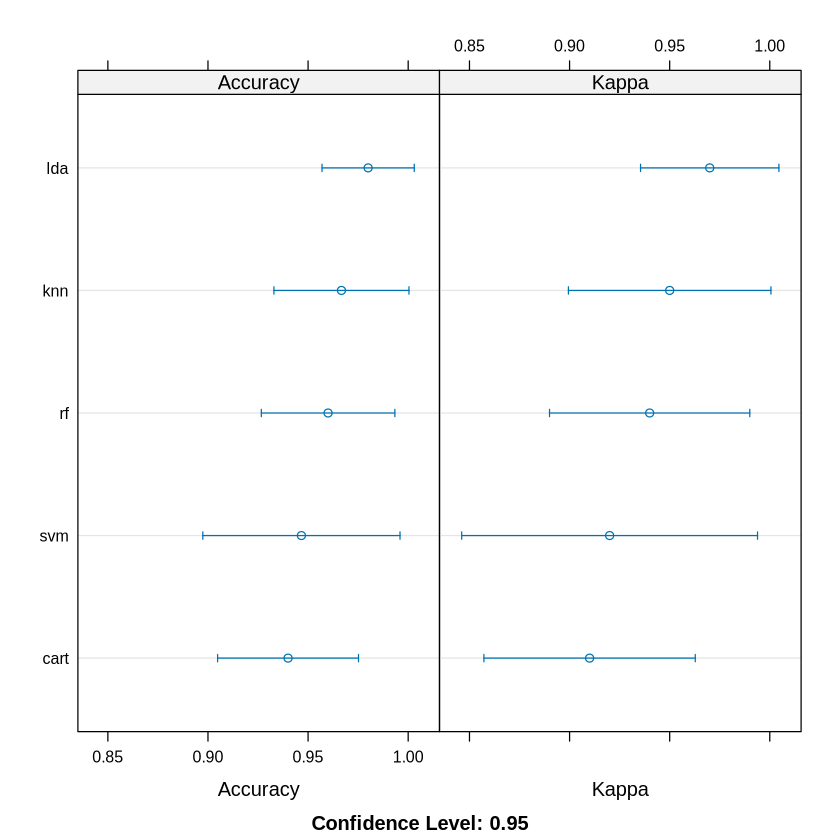

In [48]:
# compare accuracy of models
dotplot(results)

In [49]:
# summarize Best Model
print(fit.lda)

Linear Discriminant Analysis 

150 samples
  4 predictor
  3 classes: 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 135, 135, 135, 135, 135, 135, ... 
Resampling results:

  Accuracy  Kappa
  0.98      0.97 



## 6. Make Predictions
We must choose an algorithm to use to make predictions.

The results in the previous section suggest that the SVM was perhaps the most accurate model. We will use this model as our final model.

Now we want to get an idea of the accuracy of the model on our validation set.

This will give us an independent final check on the accuracy of the best model. It is valuable to keep a validation set just in case you made a slip during training, such as overfitting to the training set or a data leak. Both of these issues will result in an overly optimistic result.

### 6.1 Make Predictions
We can fit the model on the entire training dataset and make predictions on the validation dataset.

In [52]:
# Make predictions on validation dataset
predictions <- predict(fit.lda, validation)
confusionMatrix(predictions, validation$Species)

Confusion Matrix and Statistics

                 Reference
Prediction        Iris-setosa Iris-versicolor Iris-virginica
  Iris-setosa              10               0              0
  Iris-versicolor           0              10              1
  Iris-virginica            0               0              9

Overall Statistics
                                          
               Accuracy : 0.9667          
                 95% CI : (0.8278, 0.9992)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 2.963e-13       
                                          
                  Kappa : 0.95            
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Iris-setosa Class: Iris-versicolor
Sensitivity                      1.0000                 1.0000
Specificity                      1.0000                 0.9500
Pos Pred Value                   1.0000                 0.9091
Neg Pred Value

In [33]:
# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9666666666666667
[[11  0  0]
 [ 0 12  1]
 [ 0  0  6]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       1.00      0.92      0.96        13
 Iris-virginica       0.86      1.00      0.92         6

       accuracy                           0.97        30
      macro avg       0.95      0.97      0.96        30
   weighted avg       0.97      0.97      0.97        30



## Summary
In this notebook, you discovered step-by-step how to complete your first machine learning project in R.

You discovered that completing a small end-to-end project from loading the data to making predictions is the best way to get familiar with a new platform.

